** Deep Consensus Network - Colaboratory**

In [0]:
%load_ext autoreload
%reload_ext autoreload

In [0]:
import keras
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, AveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.optimizers import RMSprop, Adadelta, Adam, SGD, Adamax, Adagrad

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Call the location of the drive
!ls "/content/drive/My Drive/J91"

cryosparc_P11_J91_simulated_particles.cs  job.log  simulated_particles.mrcs


In [0]:
# Location variables
fname1 = "/content/drive/My Drive/J85/simulated_particles.mrcs"
fname2 = "/content/drive/My Drive/J91/simulated_particles.mrcs"

In [0]:
import os
os.chdir("/content/drive/My Drive/DIP/")
!ls mrc.py

mrc.py


In [0]:
import mrc

In [0]:
# Define Batch Size and Image size
num=1000  # Bacth Size
n_crop= 380 # Image size (380x380)

In [0]:
particles_hires = mrc.read_imgs(fname1,idx=0,num=num).swapaxes(0,1).swapaxes(0,2)
particles_lowres = mrc.read_imgs(fname2,idx=0,num=num).swapaxes(0,1).swapaxes(0,2)
stack = np.vstack([particles_hires,particles_lowres])

**Crop**

match 128x128 in Deep Consensus

In [0]:
nz,nx,ny=stack.shape

In [0]:
stack = np.vstack([particles_hires,particles_lowres])
stack = stack[:,int(nx/2-n_crop/2):int(nx/2+n_crop/2),int(nx/2-n_crop/2):int(nx/2+n_crop/2)]

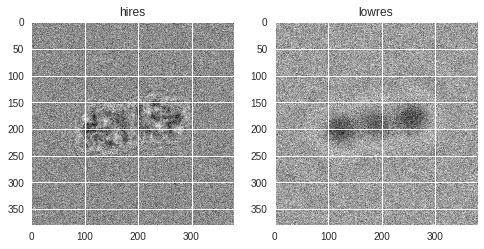

In [0]:
fig = plt.figure()
a = fig.add_subplot(121)
a.set_title('hires')
plt.imshow(stack[0],cmap='gray')

a = fig.add_subplot(122)
a.set_title('lowres')
plt.imshow(stack[-1],cmap='gray')

In [0]:
o_x_train = stack
o_y_train = np.append(np.zeros(num),np.ones(num))
#np.random.shuffle(o_y_train) # garble labels to check if evaluation accuracy is 50%

In [0]:
x_train, x_val, y_train, y_val = train_test_split(o_x_train, o_y_train,
                                                  test_size=0.1,
                                                  random_state=20) # does random shuffle for us

y_train_targ = pd.get_dummies(y_train)
y_val_targ = pd.get_dummies(y_val)

x_train = x_train[:,:,:,np.newaxis]
x_val = x_val[:,:,:,np.newaxis]


print('The Training set images have this shape: ' + str(x_train.shape))
print('The Training set labels have this shape: ' + str(y_train_targ.shape))
print('The Validation set images have this shape: ' + str(x_val.shape))
print('The Validation set labels have this shape: ' + str(y_val_targ.shape))

The Training set images have this shape: (1800, 380, 380, 1)
The Training set labels have this shape: (1800, 2)
The Validation set images have this shape: (200, 380, 380, 1)
The Validation set labels have this shape: (200, 2)


In [0]:
#check image shape
x_train[0].shape

(380, 380, 1)

**Set up model**

see the architecture in the Deep Consensus paper (Table 1 in doi:10.1107/S2052252518014392)

note defaults in keras documentation (eg strides=1)

padding='same' to match Deep Consensus Table 1

In [0]:
# Definition of paramaters depending of the number of layers

blocks = 5 # Each block has 5 layers = 2 Conv2D + 1 Activation + 1 Normalization + 1 Pooling

""" k1_size = Kernel size of the first Conv2D layer
    K2_size = Kernel size of the second Conv2D layer
    pool1 = max pooling size
"""


#inputl_kernel = [k1_size,k2_size]
"""Represents the kernel size of the first layer of the network or call input layer"""
inputl_kernel = [15,15]

#inputl_node =  [node1_number, node2_number]
"""Represents the number of node that each CONV2D layer has in the first layer"""
inputl_node = [8,8]

#hiddenl_kernel = [k3_size, k4_size, k5_size,k6_size,...] # Depends on the number of layers
"""Represents the kernel size of the hidden layers of the network"""
hiddenl_kernel = [7, 7, 3, 3]

# hiddenl_node = [node3_number, node4_number, node5_number, node6_number,...] # Depends on the number of layers
"""Represents the number of node that each CONV2D layer has in the hidden layers"""
hiddenl_node = [8,16,32,32]

# pooling_size = [pool1_size, pool2_size, pool3_size, ...] # Depends on the number of layers
"""Represents the size of pooling layer in the input and hidden layer"""
pooling_size = [7,5,3]


# Penultimate Block
# av_pool = [node1_number, node2_number, k1_size, k2_size, av_pool_size]
#average_pool= [64, 64, 3, 3, 4]
n1_ave_pool = 64
n2_ave_pool = 64
k1_ave_pool = 3
k2_ave_pool = 3 
av_pool = 4

# Output Layer = Full connected network
# output_layer = [val_dense, drop]
#output_layer = [512, 0.75]
val_dense = 64
drop = 0.75


In [0]:
# Import py file from google drive 

from customizable_deep_network import build_network

In [0]:
# Build the network
input_shape=x_train.shape[1::] # Define input shape
n_classes = np.unique(o_y_train.tolist()).size # Define number of classes

# Call function build_network

model = build_network (blocks,input_shape, inputl_node,inputl_kernel,hiddenl_node,
                     hiddenl_kernel, pooling_size, n1_ave_pool, n2_ave_pool, 
                     k1_ave_pool, k2_ave_pool, av_pool, val_dense, drop, n_classes)

In [0]:
# Print Model Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 380, 380, 8)       1808      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 380, 380, 8)       14408     
_________________________________________________________________
activation_8 (Activation)    (None, 380, 380, 8)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 380, 380, 8)       32        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 190, 190, 8)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 190, 190, 8)       3144      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 190, 190, 16)      6288      
__________

### Optimizer ###

Define optimizer and train the model

In [0]:
# Different optimizer
# SGD
# RMSprop
# Adagrad
# Adadelta
# Adam
# Adamax

# Arguments SGD
'''
    lr: float >= 0. Learning rate.
    momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.
    decay: float >= 0. Learning rate decay over each update.
    nesterov: boolean. Whether to apply Nesterov momentum.
'''

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)


# Arguments RMSprop
'''RMSProp optimizer.
It is recommended to leave the parameters of this optimizer at their default values (except the learning rate, which can be freely tuned).
This optimizer is usually a good choice for recurrent neural networks.
    lr: float >= 0. Learning rate.
    rho: float >= 0.
    epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
    decay: float >= 0. Learning rate decay over each update.
'''

rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)


# Arguments Adagrad
'''Adagrad optimizer.
Adagrad is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. The more updates a parameter receives, the smaller the learning rate.
It is recommended to leave the parameters of this optimizer at their default values.
    lr: float >= 0. Initial learning rate.
    epsilon: float >= 0. If None, defaults to K.epsilon().
    decay: float >= 0. Learning rate decay over each update.
'''
adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)


# Arguments Adadelta
'''Adadelta optimizer.
Adadelta is a more robust extension of Adagrad that adapts learning rates based on a moving window of gradient updates, instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates have been done. Compared to Adagrad, in the original version of Adadelta you don't have to set an initial learning rate. In this version, initial learning rate and decay factor can be set, as in most other Keras optimizers.
It is recommended to leave the parameters of this optimizer at their default values.
    lr: float >= 0. Initial learning rate, defaults to 1. It is recommended to leave it at the default value.
    rho: float >= 0. Adadelta decay factor, corresponding to fraction of gradient to keep at each time step.
    epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
    decay: float >= 0. Initial learning rate decay.
'''
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)


# Arguments Adam
'''Adam optimizer.
Default parameters follow those provided in the original paper.
    lr: float >= 0. Learning rate.
    beta_1: float, 0 < beta < 1. Generally close to 1.
    beta_2: float, 0 < beta < 1. Generally close to 1.
    epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
    decay: float >= 0. Learning rate decay over each update.
    amsgrad: boolean. Whether to apply the AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and Beyond".
'''
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


# Arguments Adamax
'''Adamax optimizer from Adam paper's Section 7.
It is a variant of Adam based on the infinity norm. Default parameters follow those provided in the paper.
    lr: float >= 0. Learning rate.
    beta_1: floats, 0 < beta < 1. Generally close to 1.
    beta_2: floats, 0 < beta < 1. Generally close to 1.
    epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
    decay: float >= 0. Learning rate decay over each update.
'''
adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)



model.compile(optimizer = 'adam' , loss='categorical_crossentropy', metrics=['categorical_accuracy'])



In [0]:
# Training Model

%%time
model.fit(x_train, y_train_targ.values, epochs=5, batch_size=int(x_train.shape[0]/100))

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1800/1800 [==============================] - 70s 39ms/step - loss: 0.4287 - categorical_accuracy: 0.9672
Epoch 2/5
1800/1800 [==============================] - 63s 35ms/step - loss: 0.0059 - categorical_accuracy: 0.9994
Epoch 3/5
1800/1800 [==============================] - 63s 35ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 4/5
1800/1800 [==============================] - 63s 35ms/step - loss: 0.0090 - categorical_accuracy: 0.9994
Epoch 5/5
1800/1800 [==============================] - 63s 35ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
CPU times: user 2min 38s, sys: 1min 34s, total: 4min 13s
Wall time: 5min 23s


In [0]:
# Validadtion Process

%%time
scores = model.evaluate(x_val, y_val_targ.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

200/200 [==============================] - 4s 20ms/step

categorical_accuracy: 100.00%
CPU times: user 1.81 s, sys: 1.27 s, total: 3.08 s
Wall time: 4.07 s


### Performance Graphs###

https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

In [0]:
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)